# Validate CNN CHM with airborne lidar grids (LVIS): 
### read in & concat large data frame and plot
Paul Montesano  
Oct 2023

In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

import sklearn.metrics as metrics
from scipy import stats


/tmp/ipykernel_3346778/615917861.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Paths from Sept 2023 work

In [4]:
# NOTE - we should organize our various main dirs so that the structures are the same - this makes the code easier to run
OUT_CHM_SUBSET = 'dm_10m'
OUT_CHM = '20231014_chm'
dir_main = f'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/{OUT_CHM}'

## Setup Paths

In [5]:
dir_chm = f'{dir_main}/{OUT_CHM_SUBSET}'

dir_validate_main =   f'{dir_chm}/validate' # validation subdirs will sit here
!mkdir -p $dir_validate_main
dir_footprints = f'{dir_chm}/footprints'
!mkdir -p $dir_footprints

nowtime = pd.Timestamp.now().strftime('%Y%m%d')
nowtime

dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate'

In [6]:
dir_val_csv = os.path.join(dir_validate_main, 'LVISRH050_RH075_RH098')
dir_val_smry = os.path.join(os.path.dirname(dir_val_csv), 'summaries')
!mkdir -p $dir_val_smry
dir_val_smry

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/summaries'

#### vhr metadata

In [7]:
# OUTDIR_SRLITE = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1'
# TARGET = 'alaska*'
# TARGET_DIR_TOA = f'{OUTDIR_SRLITE}/toa/{TARGET}'
# SEARCH_STRING = '/**/*.xml'

TARGET_DIR_TOA = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m'
SEARCH_STRING = '/*.xml'
f_list_toa_xml = glob.glob(f"{TARGET_DIR_TOA}{SEARCH_STRING}", recursive=True)
len(f_list_toa_xml)

3323

In [8]:
%%time

import importlib
importlib.reload(vhrlib)

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)
vhr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3323 entries, 0 to 0
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   satid       3323 non-null   object             
 1   catid       3323 non-null   object             
 2   tlctime     3323 non-null   datetime64[ns, UTC]
 3   gsd         3323 non-null   float64            
 4   sunaz       3323 non-null   float64            
 5   sunel       3323 non-null   float64            
 6   az          3323 non-null   float64            
 7   el          3323 non-null   float64            
 8   intrack     3323 non-null   float64            
 9   crosstrack  3323 non-null   float64            
 10  offnadir    3323 non-null   float64            
 11  cloudcover  3323 non-null   float64            
 12  scandir     3323 non-null   object             
 13  ULLON       3323 non-null   float64            
 14  ULLAT       3323 non-null   float64        

### Read in the validation CSVs

predictions made at 2m, reference LVIS is 30m, validation done at 10m --> 5 pix x 5 pix are averaged for each validation observation

In [9]:
%%time
if True:
    with Pool(processes=35) as pool:
        DF_VAL_LIST = pool.map(partial(pd.read_csv), glob.glob(dir_val_csv + '/*.csv') )
else:
    DF_VAL_LIST = [pd.read_csv(f) for f in glob.glob(dir_val_csv + '/*.csv')]
df_val = pd.concat(DF_VAL_LIST)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260935361 entries, 0 to 2843
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ht_m_src        float64
 1   ht_m_ref_RH050  float64
 2   ht_m_ref_RH075  float64
 3   ht_m_ref_RH098  float64
 4   tcc_ref         float64
 5   slope_ref       float64
 6   cnt_ref         float64
 7   tcc_class       object 
 8   file            object 
 9   date            object 
 10  type            object 
 11  footprint_name  object 
 12  catid           object 
 13  sensor          object 
 14  year            int64  
 15  month           int64  
dtypes: float64(7), int64(2), object(7)
memory usage: 33.1+ GB
CPU times: user 1min 16s, sys: 42.6 s, total: 1min 58s
Wall time: 1min 55s


## Calc validation smry stats

In [10]:
def validation_smry_stats(g, ref_var, src_var):
    n = len(g)
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(g[ref_var], g[src_var])

    # Regression metrics
    explained_variance =  metrics.explained_variance_score(g[ref_var], g[src_var])
    mean_absolute_error = metrics.mean_absolute_error(g[ref_var], g[src_var]) 
    mse                 = metrics.mean_squared_error(g[ref_var], g[src_var]) 
    rmse                = np.sqrt(mse) 
    #mean_squared_log_error=metrics.mean_squared_log_error(g[ref_var], g[src_var])
    median_absolute_error = metrics.median_absolute_error(g[ref_var], g[src_var])
    r2score             = metrics.r2_score(g[ref_var], g[src_var])

    if False:
        print('explained_variance: ', round(explained_variance,4))    
        #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
        print('r2: ', round(r2score,4))
        print('MAE: ', round(mean_absolute_error,4))
        print('MSE: ', round(mse,4))
        print('RMSE: ', round(rmse,4))

    return pd.Series(dict(n=n, slope=slope, intercept=intercept, r_value=r_value, p_value=p_value, std_err=std_err, ref_var=ref_var, r2score = r2score, expvarscore=explained_variance, mae=mean_absolute_error, mse=mse, rmse=rmse, medae=median_absolute_error))   

## Summarize predicted vs observed
 - footprint summary  
 find which are train and non-train

 - separate VHR strips into 'training' (strips used to train the model) and 'non-training'  
 - in theory, strips used to train the model should have better results  
 - good results for strips from 'non-training' indicate a robust model  

In [11]:
LIST_REF_METRICS = ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098']

In [12]:
%%time
df_smry_footprint_list = [df_val.groupby(['footprint_name']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in LIST_REF_METRICS ]
df_smry_footprint = pd.concat(df_smry_footprint_list, axis=0)
df_smry_footprint = footprintlib.get_attributes_from_filename(df_smry_footprint, file_col='footprint_name', image_type='CHM pred', file_split_str='-chm-dm-10m.tif', DROP_FILE_DUPLICATES=False)
df_smry_footprint

CPU times: user 2min 27s, sys: 30.4 s, total: 2min 57s
Wall time: 2min 57s


,footprint_name,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae,type,catid,sensor,year,month,date
0,WV02_20100715_M1BS_10300100064B1E00,3216,0.135678,0.201304,0.462885,1.559481e-170,0.004583,ht_m_ref_RH050,0.172792,0.185440,0.690192,2.860685,1.691356,0.298571,CHM pred,10300100064B1E00,WV02,2010,7,2010-07-15
1,WV02_20100804_M1BS_103001000617C000,740774,1.046244,1.553476,0.842051,0.000000e+00,0.000779,ht_m_ref_RH050,0.102813,0.548695,1.751282,5.309372,2.304207,1.532273,CHM pred,103001000617C000,WV02,2010,8,2010-08-04
2,WV02_20100824_M1BS_10300100066AFE00,444337,0.864831,0.465248,0.724265,0.000000e+00,0.001235,ht_m_ref_RH050,-0.251149,0.303831,0.499573,0.497695,0.705475,0.286667,CHM pred,10300100066AFE00,WV02,2010,8,2010-08-24
3,WV02_20110727_M1BS_103001000D914900,1037606,0.084926,0.045149,0.038057,0.000000e+00,0.002189,ht_m_ref_RH050,-21.947137,-4.809925,0.251990,0.083734,0.289368,0.228750,CHM pred,103001000D914900,WV02,2011,7,2011-07-27
4,WV02_20110804_M1BS_103001000C140300,1050685,0.603069,0.731253,0.518995,0.000000e+00,0.000969,ht_m_ref_RH050,-0.189340,-0.144091,1.080566,2.498053,1.580523,0.691875,CHM pred,103001000C140300,WV02,2011,8,2011-08-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,WV03_20200714_M1BS_104001005E7EAE00,342790,-0.019681,0.016373,-0.024711,1.869362e-47,0.001360,ht_m_ref_RH098,-110.661200,-0.673646,0.578301,0.338538,0.581840,0.574000,CHM pred,104001005E7EAE00,WV03,2020,7,2020-07-14
434,WV03_20200715_M1BS_104001005EC99000,324873,0.000917,0.000913,0.005275,2.639501e-03,0.000305,ht_m_ref_RH098,-41.262087,-0.028363,0.809183,0.670926,0.819101,0.831667,CHM pred,104001005EC99000,WV03,2020,7,2020-07-15
435,WV03_20200729_M1BS_104001005E8CBF00,916145,0.398769,-0.223723,0.835455,0.000000e+00,0.000274,ht_m_ref_RH098,0.150371,0.569715,1.075640,2.208841,1.486217,0.730000,CHM pred,104001005E8CBF00,WV03,2020,7,2020-07-29
436,WV03_20200802_M1BS_104001005F4BBC00,98523,0.086126,-0.087861,0.545804,0.000000e+00,0.000421,ht_m_ref_RH098,-1.716872,0.147352,2.225789,7.219959,2.686998,1.733333,CHM pred,104001005F4BBC00,WV03,2020,8,2020-08-02


In [13]:
list_val_footprints = df_smry_footprint.groupby('catid').aggregate(cnt_metrics=('catid','count')).reset_index().catid.to_list()

### Divide into training and non-training sets

In [14]:
strips_train_df = pd.read_csv(os.path.join(dir_main , 'train_strips_0708_arcBorC_v20231017.csv'))
strips_nontrain_df = pd.read_csv(os.path.join(dir_main , 'nontrain_strips_0708_arcBorC_v20231017.csv'))

strips_train_df['footprint_name'] = strips_train_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_train_df['catid'] = strips_train_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_train = strips_train_df.catid.to_list()
strips_nontrain_df['footprint_name'] = strips_nontrain_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_nontrain_df['catid'] = strips_nontrain_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_nontrain = strips_nontrain_df.catid.to_list()

list_strips_val_train = [x for x in list_strips_train if x in list_val_footprints]
list_strips_val_nontrain = [x for x in list_strips_nontrain if x in list_val_footprints]

print(f"Strips used:")
print(f"\tfrom model training set:\t{len(list_strips_train)}")
print(f"\tfrom non-training set:\t\t{len(list_strips_nontrain)}")

print(f"Total strips:\t\t\t\t{len(list_strips_train) + len(list_strips_nontrain)}\n")
print(f"Strips used for this validation:\t{len(list_val_footprints)}")
print(f"\tfrom the model-training set:\t{len(list_strips_val_train)}")
print(f"\tfrom the non-training set:\t{len(list_strips_val_nontrain)}")

Strips used:
	from model training set:	526
	from non-training set:		424
Total strips:				950

Strips used for this validation:	438
	from the model-training set:	202
	from the non-training set:	236


Now we have a table by strip that summarizes validation results with LVIS RH050, RH075, and RH098. Some of these strips are sub-optimal due to:
 - poor VHR SSG
 - cloud & cloud-shadow contamination (need to improve masking of this noise)
that will yield
 - poor SRlite and SRLite-bsed CHM estimates
 
 These data can be filtered out through metadata joins below...

In [15]:
stats_footprint_smry_fn = os.path.join(dir_validate_main, f'stats_footprint_smry_{os.path.basename(dir_val_csv)}.csv')

## Update footprint summary: VHR info and SRlite metrics

#### Examine VHR metadata for filtering

In [16]:
df_smry_footprint_updated = pd.merge(df_smry_footprint, vhr_df.drop(columns=['URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE','ULLON','ULLAT','ULHAE']), how='left', on=['catid'])
df_smry_footprint_updated.to_csv(stats_footprint_smry_fn)
stats_footprint_smry_fn

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/stats_footprint_smry_LVISRH050_RH075_RH098.csv'

#### TODO - Examine SRlite metadata for filtering
`srlite_metrics.ipynb`

In [17]:
####df_stats_smry_updated = pd.merge(df_stats_smry_updated,  , how='left', on=['catid'])
#df_stats_smry_updated.to_csv(stats_footprint_smry_fn)
#stats_footprint_smry_fn


#### Strips the the SRlite metrics assessment said where good
 - based on NIR r2 threshold of 0.75  
 - not yet filtered down to July/Aug

In [18]:
list_include_footprints = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_include_model_0p75.txt',sep=',', header=None)[0].tolist()
print(len(list_include_footprints))

list_exclude_footprints = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_exclude_model_0p75.txt',sep=',', header=None)[0].tolist()
len(list_exclude_footprints)

1735


1479

In [19]:
def srlite_metrics_classifier(row, THRESH=0.75):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.75 from srlite_metrics.ipynb
    if row["catid"] in list_include_footprints:
        return f"include\nNIR r2 >= {THRESH}"
    else:
        return f"exclude\nNIR r2 < {THRESH}"  

def model_use_classifier(row):
    if row["catid"] in list_strips_val_train:
        return "train"
    else:
        return "non-train" 

df_smry_footprint_updated['srlite_metrics_class'] = df_smry_footprint_updated.apply(srlite_metrics_classifier, axis=1)
df_smry_footprint_updated['model_train_class'] = df_smry_footprint_updated.apply(model_use_classifier, axis=1)

CPU times: user 7.59 ms, sys: 0 ns, total: 7.59 ms
Wall time: 7.71 ms


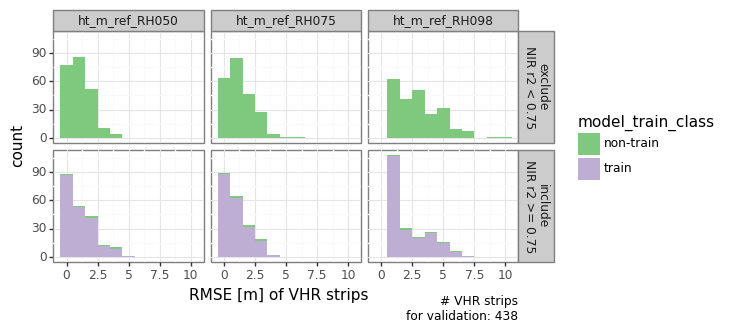

<ggplot: (1437091309803)>

In [20]:
%%time

(
    ggplot(df_smry_footprint_updated, aes('rmse', fill='model_train_class')) 
    + geom_histogram(binwidth=1)
    + labs(x = 'RMSE [m] of VHR strips', caption=f"# VHR strips\nfor validation: {int(len(df_smry_footprint_updated)/len(LIST_REF_METRICS))}")
    + theme_bw()
    + scale_fill_brewer(type='qual')
    + facet_grid('srlite_metrics_class~ref_var')
    + theme(figure_size=(6, 3))
)

#### Summarize: 
Distribution of validation observations:  
 - footprints  
 - TCC intervals

In [21]:
%%time
df_smry_footprint_tcc = df_val.groupby(['footprint_name']).aggregate({'tcc_class':'first', 'footprint_name':'count'}).rename(columns={'footprint_name':'n_obs'})#.count().add_suffix('_count')
df_smry_footprint_tcc.reset_index(inplace=True)

CPU times: user 33 s, sys: 2.73 s, total: 35.8 s
Wall time: 35.7 s


In [22]:
df_smry_footprint_tcc['catid'] = df_smry_footprint_tcc['footprint_name'].str.split('-', expand=True)[0].str.split('_', expand=True)[3]
df_smry_footprint_tcc.head(10)

,footprint_name,tcc_class,n_obs,catid
0,WV02_20100715_M1BS_10300100064B1E00-chm-dm-10m...,41-60%,3216,10300100064B1E00
1,WV02_20100804_M1BS_103001000617C000-chm-dm-10m...,21-40%,740774,103001000617C000
2,WV02_20100824_M1BS_10300100066AFE00-chm-dm-10m...,0-20%,444337,10300100066AFE00
3,WV02_20110727_M1BS_103001000D914900-chm-dm-10m...,0-20%,1037606,103001000D914900
4,WV02_20110804_M1BS_103001000C140300-chm-dm-10m...,21-40%,1050685,103001000C140300
5,WV02_20110812_M1BS_103001000C8BBA00-chm-dm-10m...,0-20%,500176,103001000C8BBA00
6,WV02_20110812_M1BS_103001000D56BA00-chm-dm-10m...,21-40%,1658325,103001000D56BA00
7,WV02_20110812_M1BS_103001000DCAF400-chm-dm-10m...,0-20%,38385,103001000DCAF400
8,WV02_20110815_M1BS_103001000D5B3F00-chm-dm-10m...,0-20%,628595,103001000D5B3F00
9,WV02_20110822_M1BS_103001000D4CC000-chm-dm-10m...,0-20%,476959,103001000D4CC000


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_fill_brewer could not recognise parameter `guides`


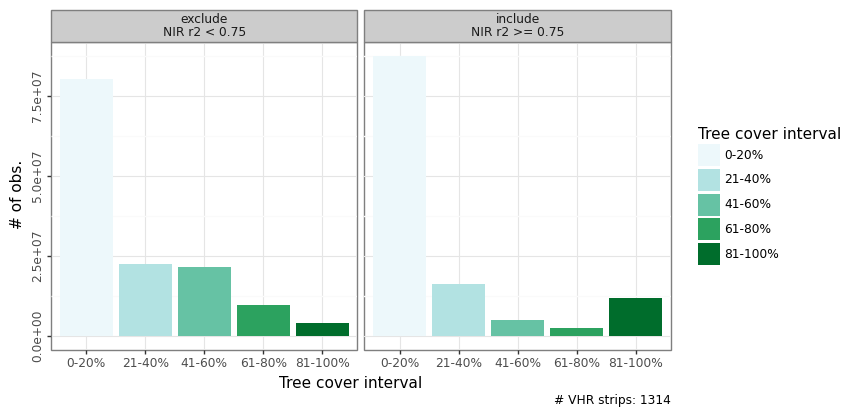

<ggplot: (1437090189403)>

In [27]:
from mizani.formatters import scientific_format

df_smry_footprint_tcc['include_class'] = df_smry_footprint_tcc.apply(srlite_metrics_classifier, axis=1)

(
    ggplot(df_smry_footprint_tcc, aes(x='tcc_class', y='n_obs', fill='tcc_class') )
    + geom_bar(stat = "identity")
    + geom_label(x=4, y=3e8, label=f'n = {df_val.shape[0]:,}', fill='white')
    + theme_bw()
    + scale_fill_brewer(type='seq', palette=2, guides=True, name='Tree cover interval') 
    + scale_y_continuous(labels=scientific_format(digits=1))
    + theme(figure_size=(8, 4), axis_text_y = element_text(angle=90),axis_text_x = element_text(angle=0))
    + labs(x='Tree cover interval', y='# of obs.', caption=f"# VHR strips: {len(df_smry_footprint)}")
    + facet_wrap('~include_class',ncol=2)
)

In [ ]:
# def plot_scatter(df_val, sample_frac, df_val_smry, ref_var, facet_var=None):
    
#     # Get # VHR strips
#     n_VHR = len(df_val.groupby(['footprint_name']).aggregate({'footprint_name':'count'}))
    
#     # Subsetting... instead of melting...
#     df_val_smry = df_val_smry[df_val_smry.ref_var == ref_var]
#     df_val_smry['rmse'] = round(df_val_smry['rmse'], 2)
    
#     #calculate best fit line
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df_val[ref_var], df_val['ht_m_src'])
#     df_val['fit'] = df_val[ref_var] * slope + intercept
    
#     max_val = 30
#     p = (
#         ggplot(
#             df_val.sample(frac=sample_frac),
#             aes(x=ref_var, y='ht_m_src')
#         )
#             + labs(title='', x=f"Reference Canopy Height [m]: {ref_var.split('_')[-1]}", y='Predicted Canopy Height [m]')
#             + geom_bin2d(binwidth=0.25)
#         + geom_abline(linetype='dashed')
#         + annotate(geom='label', x=0, y=max_val, label=f"$r^2$: {round(r_value*r_value,2)}", ha='left', va='top')
#         + annotate(geom='label', x=0, y=max_val-4, label=f"rmse [m]: {df_val_smry['rmse'][0]}", ha='left', va='top')
#         + annotate(geom='label', x=0, y=max_val-8,  label=f"bias [m]: {round(intercept,2)}", ha='left', va='top')
#         + annotate(geom='label', x=20, y=max_val,   label=f"# obs: {len(df_val):,}", ha='left', va='top')
#         + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
#         + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
#         + scale_fill_cmap(cmap_name='plasma', trans='log10', name='n obs. 10 m')
        
#         #+ facet_grid(' ~ month')
#         + theme_bw()
#         + theme(figure_size=(6, 4), strip_text = element_text(size=9))
#         + labs(caption=f'{os.path.basename(dir_val_csv)}')
#     )
#     if sample_frac < 1:
#         p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') )
#     if facet_var is not None:
#         p = ( p + facet_wrap(f"~{facet_var}") )
#     print(p)

In [ ]:
# def plot_scatter_melt(df_val, sample_frac, ref_var, FACET_VAR=None, LIST_ID_VARS=['year']):
    
# #     # Get count of various groups
#     df_smry_N_VHR_YEAR = df_val.groupby(['footprint_name','year']).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby(['year']).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
#     df_smry_N_VHR_YEAR['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_YEAR['n_VHR'].astype(str)
#     N_VHR   = len(df_smry_N_aVHR)
#     df_smry_N_YEARS = df_val.groupby(['year']).aggregate(n_obs_year=('year','count')).reset_index()
#     df_smry_N_YEARS['n_obs_year_str'] = f"# obs: " + df_smry_N_YEARS['n_obs_year'].astype(str)
#     N_YEARS = len(df_smry_N_YEARS)
# #     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
# #     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()
    
#     # Run the validation stats
#     df_validation_smry_stats = round(df_val.groupby(LIST_ID_VARS).apply(validation_smry_stats, ref_var, 'ht_m_src').reset_index(), 2)
#     df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
#     df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
#     df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
#     df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
#     df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    
#     df_val_m = pd.melt(df_val[LIST_ID_VARS+[ref_var]+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=[ref_var])
       
#     max_val = 30
#     p = (
#         ggplot(
#             df_val_m.sample(frac=sample_frac),
#             aes(x='value', y='ht_m_src', group=FACET_VAR)
#         )
#             + labs(title='', x=f"Reference Canopy Height [m]: {ref_var.split('_')[-1]}", y='Predicted Canopy Height [m]')
#             + geom_bin2d(binwidth=0.25)
#         + geom_abline(linetype='dashed')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
#         + geom_label(data=df_smry_N_YEARS, mapping=aes(x=15, y=max_val, label='n_obs_year_str'), ha='left', va='top')
#         + geom_label(data=df_smry_N_VHR_YEAR, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
#         # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
#         + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
#         + scale_fill_cmap(cmap_name='plasma', trans='log10', name='n obs. 10 m')
        
#         + facet_grid(f'{FACET_VAR} ~ variable')
#         + theme_bw()
#         + theme(figure_size=(N_YEARS*4, 4), strip_text = element_text(size=9))
#         + labs(caption=f'{os.path.basename(dir_val_csv)}')
#     )
#     if sample_frac < 1:
#         p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') )
#     if FACET_VAR is not None:
#         p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
#     print(p)
    
#     return df_validation_smry_stats

In [28]:
def plot_scatter_melt_2(df_val, sample_frac, LIST_REF_VARS, FACET_VAR='year'):
    
    LIST_ID_VARS = [FACET_VAR]
    
#     # Get count of various groups
    df_smry_N_VHR_GROUP = df_val.groupby(['footprint_name',FACET_VAR]).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby([FACET_VAR]).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
    df_smry_N_VHR_GROUP['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_GROUP['n_VHR'].astype(str)
    N_VHR   = len(df_smry_N_VHR_GROUP)
    
    df_smry_N_GROUPS = df_val.groupby([FACET_VAR]).aggregate(n_obs_group=(FACET_VAR,'count')).reset_index()
    df_smry_N_GROUPS['n_obs_group_str'] = f"# obs: " + df_smry_N_GROUPS['n_obs_group'].astype(str)
    N_GROUPS = len(df_smry_N_GROUPS)
#     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
#     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()

    # Change the names of the ref ht vars to make them look nicer
    LIST_REF_VARS = [x.split('_')[-1] for x in df_val.columns.to_list() if "RH" in x]
    rename_dict = dict(zip([x for x in df_val.columns.to_list() if "RH" in x], LIST_REF_VARS))
    df_val.rename(rename_dict, axis=1, inplace=True)

    # Melt
    df_val_m = pd.melt(df_val[LIST_ID_VARS+LIST_REF_VARS+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=LIST_REF_VARS)
    
    # Run the validation stats
    df_validation_smry_stats = round(df_val_m.groupby(LIST_ID_VARS+['variable']).apply(validation_smry_stats, 'value', 'ht_m_src').reset_index(), 2)
    df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
    df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
    df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
    df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
    df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    df_validation_smry_stats['variable'] = df_validation_smry_stats['variable'].apply(lambda x: x.split('_')[-1])
    
    max_val = 30
    p = (
        ggplot(
            df_val_m.sample(frac=sample_frac),
            aes(x='value', y='ht_m_src', group=FACET_VAR)
        )
            + labs(title='', x="Reference Canopy Height [m]", y='Predicted Canopy Height [m]')
            + geom_bin2d(binwidth=0.25)
        + geom_abline(linetype='dashed')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_GROUPS, mapping=aes(x=15, y=max_val, label='n_obs_group_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_VHR_GROUP, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
        # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
        + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
        + scale_fill_cmap(cmap_name='plasma', trans='log10', name='n obs. 10 m')
        
        + facet_grid(f'variable ~ {FACET_VAR}')
        + theme_bw()
        + theme(figure_size=(N_GROUPS*4, len(LIST_REF_VARS)*4), strip_text = element_text(size=9))
        + labs(caption=f'{os.path.basename(dir_val_csv)}')
    )
    if sample_frac < 1:
        p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') )
    # if FACET_VAR is not None:
    #     p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
    print(p)
    
    return df_validation_smry_stats

## Summarize and Plot validation obs 
#### across LVIS RH metrics

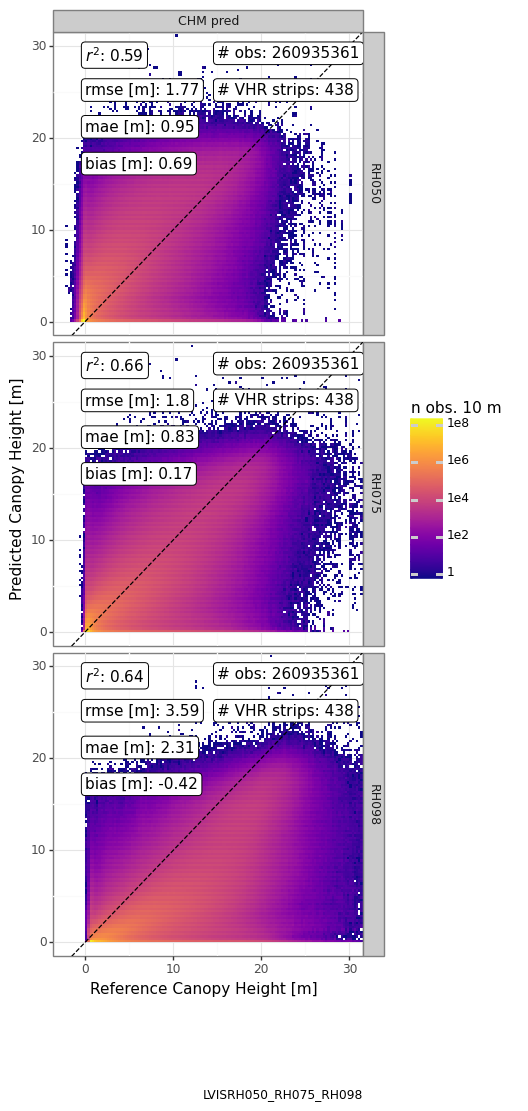


CPU times: user 1h 32min 54s, sys: 9min 36s, total: 1h 42min 30s
Wall time: 1h 42min 24s


,type,variable,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
0,CHM pred,RH050,260935361,0.94,0.69,0.77,0.0,0.0,value,0.31,0.40,0.95,3.13,1.77,0.26,0.59,$r^2$: 0.59,rmse [m]: 1.77,mae [m]: 0.95,bias [m]: 0.69
1,CHM pred,RH075,260935361,0.69,0.17,0.81,0.0,0.0,value,0.65,0.66,0.83,3.23,1.80,0.23,0.66,$r^2$: 0.66,rmse [m]: 1.8,mae [m]: 0.83,bias [m]: 0.17
2,CHM pred,RH098,260935361,0.47,-0.42,0.80,0.0,0.0,value,0.33,0.60,2.31,12.89,3.59,1.09,0.64,$r^2$: 0.64,rmse [m]: 3.59,mae [m]: 2.31,bias [m]: -0.42


In [29]:
%%time

df_validation_smry_stats = plot_scatter_melt_2(df_val.sample(frac=1), 1, ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'], FACET_VAR='type')
df_validation_smry_stats.head()

#### across LVIS RH metrics and years

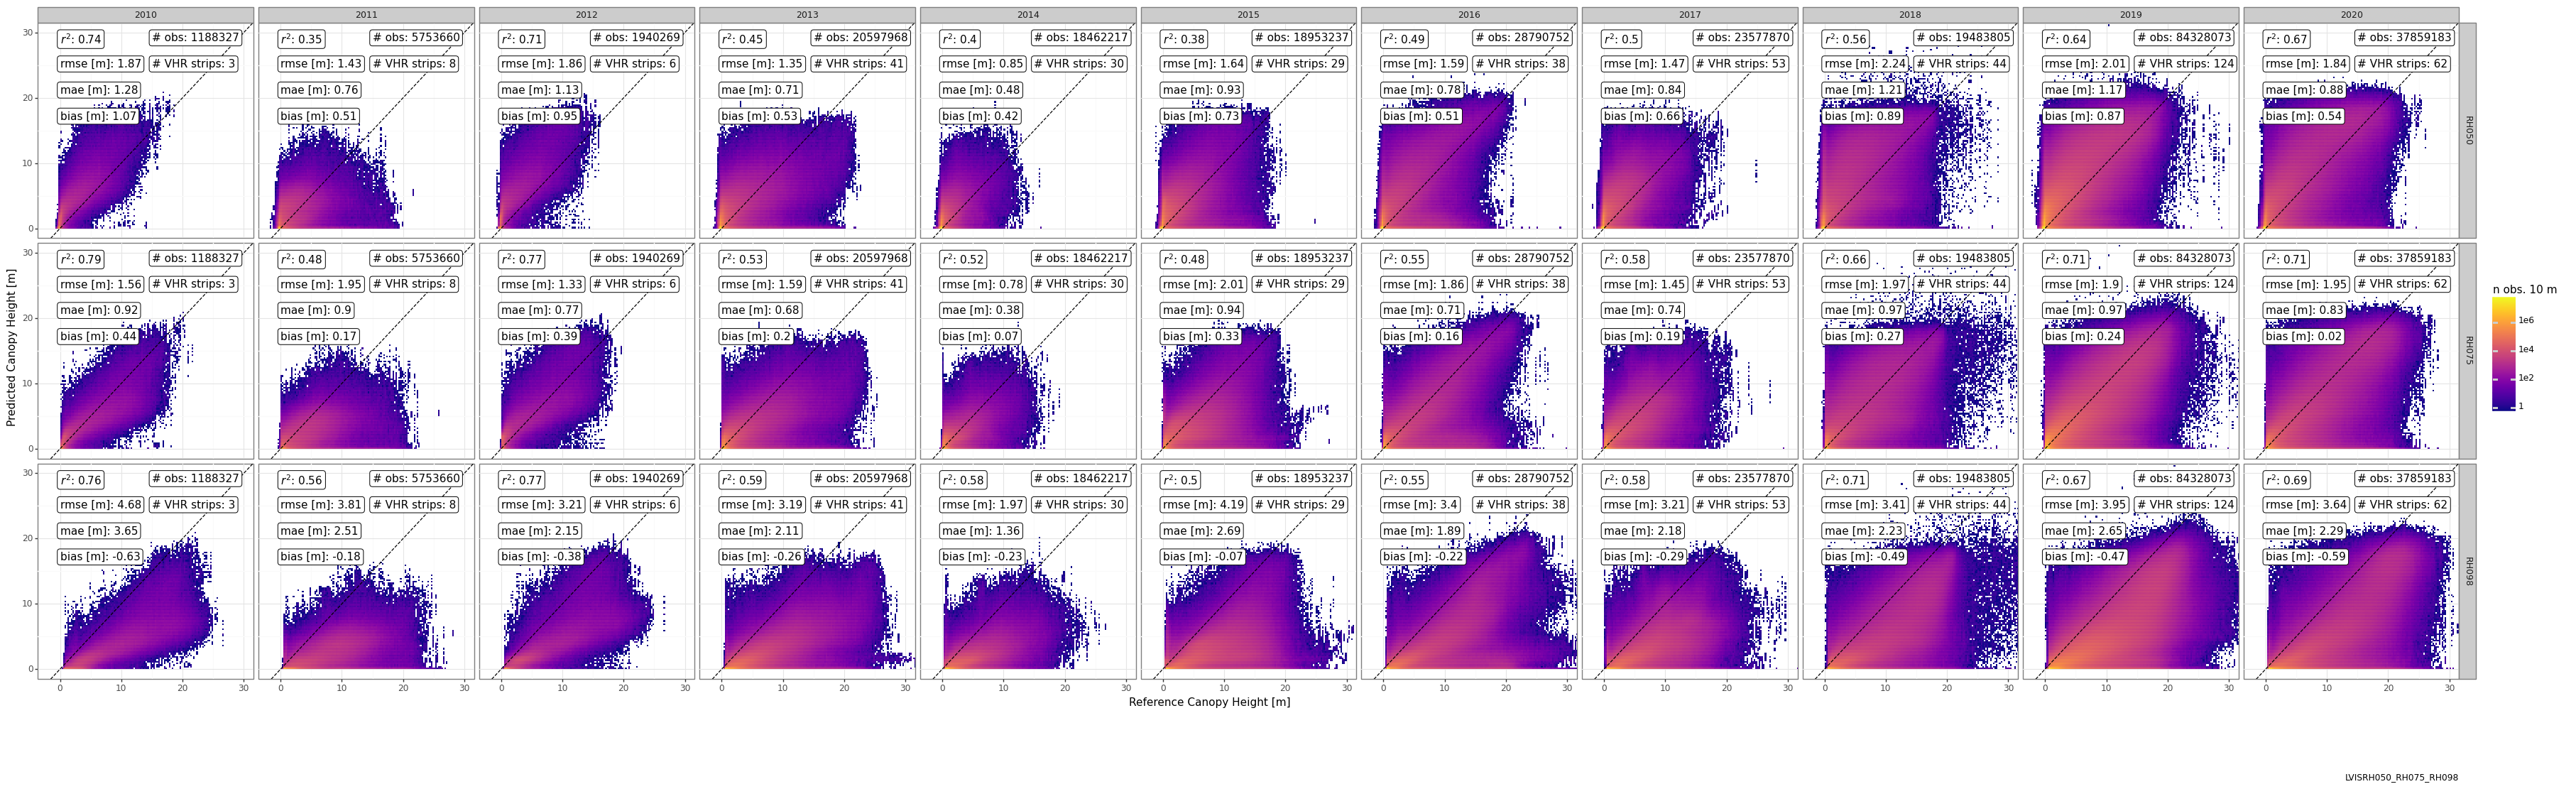


CPU times: user 1h 44s, sys: 6min 46s, total: 1h 7min 31s
Wall time: 1h 7min 27s


,year,variable,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
0,2010,RH050,1188327,1.13,1.07,0.86,0.0,0.0,value,0.21,0.53,1.28,3.50,1.87,0.84,0.74,$r^2$: 0.74,rmse [m]: 1.87,mae [m]: 1.28,bias [m]: 1.07
1,2010,RH075,1188327,0.73,0.44,0.89,0.0,0.0,value,0.78,0.79,0.92,2.42,1.56,0.43,0.79,$r^2$: 0.79,rmse [m]: 1.56,mae [m]: 0.92,bias [m]: 0.44
2,2010,RH098,1188327,0.48,-0.63,0.87,0.0,0.0,value,0.14,0.66,3.65,21.88,4.68,2.75,0.76,$r^2$: 0.76,rmse [m]: 4.68,mae [m]: 3.65,bias [m]: -0.63
3,2011,RH050,5753660,0.54,0.51,0.59,0.0,0.0,value,0.22,0.26,0.76,2.06,1.43,0.24,0.35,$r^2$: 0.35,rmse [m]: 1.43,mae [m]: 0.76,bias [m]: 0.51
4,2011,RH075,5753660,0.41,0.17,0.69,0.0,0.0,value,0.40,0.47,0.90,3.81,1.95,0.23,0.48,$r^2$: 0.48,rmse [m]: 1.95,mae [m]: 0.9,bias [m]: 0.17
5,2011,RH098,5753660,0.29,-0.18,0.75,0.0,0.0,value,0.01,0.43,2.51,14.54,3.81,1.27,0.56,$r^2$: 0.56,rmse [m]: 3.81,mae [m]: 2.51,bias [m]: -0.18
6,2012,RH050,1940269,1.30,0.95,0.84,0.0,0.0,value,-0.17,0.23,1.13,3.47,1.86,0.26,0.71,$r^2$: 0.71,rmse [m]: 1.86,mae [m]: 1.13,bias [m]: 0.95
7,2012,RH075,1940269,0.86,0.39,0.88,0.0,0.0,value,0.76,0.76,0.77,1.78,1.33,0.25,0.77,$r^2$: 0.77,rmse [m]: 1.33,mae [m]: 0.77,bias [m]: 0.39
8,2012,RH098,1940269,0.53,-0.38,0.88,0.0,0.0,value,0.47,0.70,2.15,10.32,3.21,1.01,0.77,$r^2$: 0.77,rmse [m]: 3.21,mae [m]: 2.15,bias [m]: -0.38
9,2013,RH050,20597968,0.62,0.53,0.67,0.0,0.0,value,0.32,0.38,0.71,1.81,1.35,0.24,0.45,$r^2$: 0.45,rmse [m]: 1.35,mae [m]: 0.71,bias [m]: 0.53


In [30]:
%%time

df_validation_smry_stats_YEAR = plot_scatter_melt_2(df_val.sample(frac=1), 1, ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'], FACET_VAR='year')
df_validation_smry_stats_YEAR

#### Summarize: Distribution of validation observations across LVIS RH metrics
--- replaced above---

In [354]:
# %%time
# def do_val_smry(REF_VAR):
#     return df_val.groupby(['type']).apply(validation_smry_stats, REF_VAR, 'ht_m_src').reset_index()
    
# if True:
#     with Pool(processes=3) as pool:
#         df_val_smry_list = pool.map(partial(do_val_smry), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
# else:
#     df_val_smry_list = [df_val.groupby(['type']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
    
# df_val_smry_RHmetric = pd.concat(df_val_smry_list)
# df_val_smry_RHmetric

CPU times: user 5.56 ms, sys: 3.2 s, total: 3.21 s
Wall time: 1min 23s


,type,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae
0,CHM pred,260935361,0.942324,0.685933,0.773853,0.0,0.000048,ht_m_ref_RH050,0.307607,0.401844,0.948070,3.131433,1.769586,0.257143
0,CHM pred,260935361,0.693788,0.165364,0.813118,0.0,0.000031,ht_m_ref_RH075,0.649582,0.659551,0.831717,3.227849,1.796621,0.231765
0,CHM pred,260935361,0.471787,-0.416749,0.801388,0.0,0.000022,ht_m_ref_RH098,0.333806,0.596992,2.308666,12.890435,3.590325,1.090667


### Plot overall
--- replaced above---

/tmp/ipykernel_3075465/85237052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3075465/85237052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3075465/85237052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


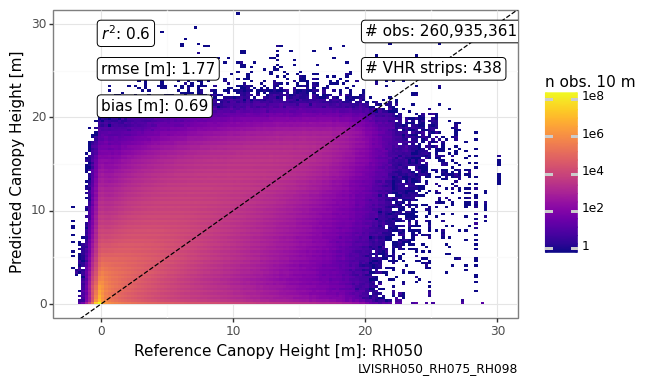

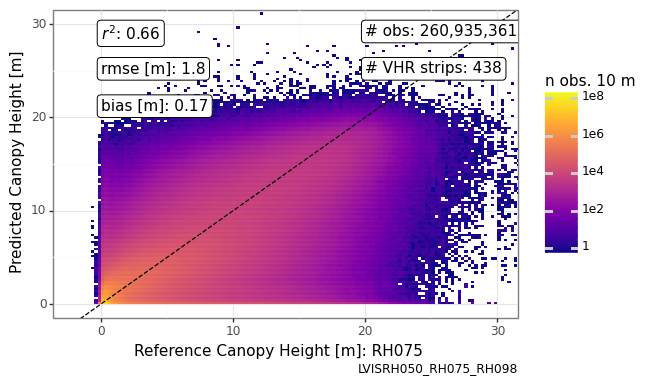

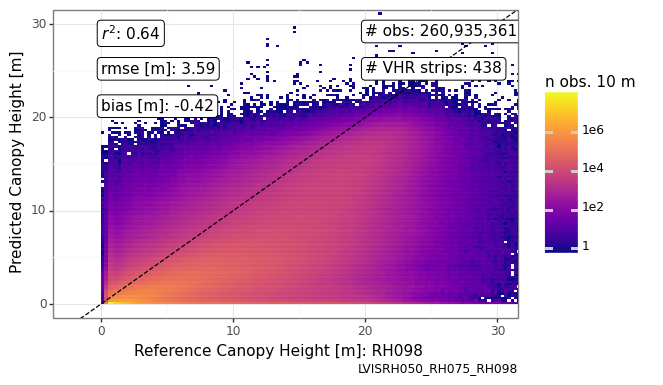


CPU times: user 2min 53s, sys: 2min 1s, total: 4min 55s
Wall time: 21min 43s


In [356]:
%%time
if True:
    with Pool(processes=3) as pool:
        p_list = pool.map(partial(plot_scatter, df_val, 1, df_val_smry_RHmetric), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
else:
    [plot_scatter(df_val, 1, df_val_smry_RHmetric, x_var) for x_var in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]

In [357]:
print(f'Validation data frame has {df_val.shape[0]/1e9:,} billion observations of 10 m pred. vs obs. canopy height estimates across Alaska')

Validation data frame has 0.260935361 billion observations of 10 m pred. vs obs. canopy height estimates across Alaska


#### Summarize: Distribution of validation observations across LVIS RH metrics  
 - year

In [243]:
%%time

df_smry_year_list = [df_val.sample(frac=1).groupby(['year']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
df_smry_year = pd.concat(df_smry_year_list).round(3)
df_smry_year.head(10)

CPU times: user 5.97 s, sys: 11.3 ms, total: 5.98 s
Wall time: 6 s


,year,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae
0,2012,140648,1.052,0.271,0.697,0.0,0.003,ht_m_ref_RH050,-0.964,-0.174,0.270,0.169,0.411,0.230
1,2013,611962,0.803,0.515,0.767,0.0,0.001,ht_m_ref_RH050,0.435,0.511,0.629,1.206,1.098,0.203
2,2014,393848,0.779,0.562,0.567,0.0,0.002,ht_m_ref_RH050,-0.586,-0.327,0.718,1.457,1.207,0.300
3,2015,116056,0.118,0.036,0.019,0.0,0.018,ht_m_ref_RH050,-84.634,-36.790,0.142,0.036,0.190,0.120
4,2016,858571,0.214,0.269,0.362,0.0,0.001,ht_m_ref_RH050,0.077,0.079,0.795,3.956,1.989,0.217
5,2017,32765,3.693,0.885,0.587,0.0,0.028,ht_m_ref_RH050,-97.827,-32.180,0.346,0.181,0.425,0.234
6,2019,640004,1.042,1.136,0.911,0.0,0.001,ht_m_ref_RH050,0.697,0.776,1.503,5.709,2.389,0.740
0,2012,140648,0.614,-0.050,0.821,0.0,0.001,ht_m_ref_RH075,0.627,0.669,0.148,0.131,0.361,0.101
1,2013,611962,0.645,0.091,0.831,0.0,0.001,ht_m_ref_RH075,0.648,0.687,0.678,1.365,1.169,0.285
2,2014,393848,0.576,0.114,0.687,0.0,0.001,ht_m_ref_RH075,0.381,0.449,0.699,1.524,1.234,0.274


### Plot stats summary results by LVIS RH

In [244]:
df_smry_year_m = pd.melt(df_smry_year, id_vars=['year', 'ref_var'] , value_vars=['r2score','expvarscore','mae','mse','rmse','medae'])
df_smry_year_m

,year,ref_var,variable,value
0,2012,ht_m_ref_RH050,r2score,-0.964
1,2013,ht_m_ref_RH050,r2score,0.435
2,2014,ht_m_ref_RH050,r2score,-0.586
3,2015,ht_m_ref_RH050,r2score,-84.634
4,2016,ht_m_ref_RH050,r2score,0.077
...,...,...,...,...
121,2014,ht_m_ref_RH098,medae,1.955
122,2015,ht_m_ref_RH098,medae,0.847
123,2016,ht_m_ref_RH098,medae,0.855
124,2017,ht_m_ref_RH098,medae,1.250


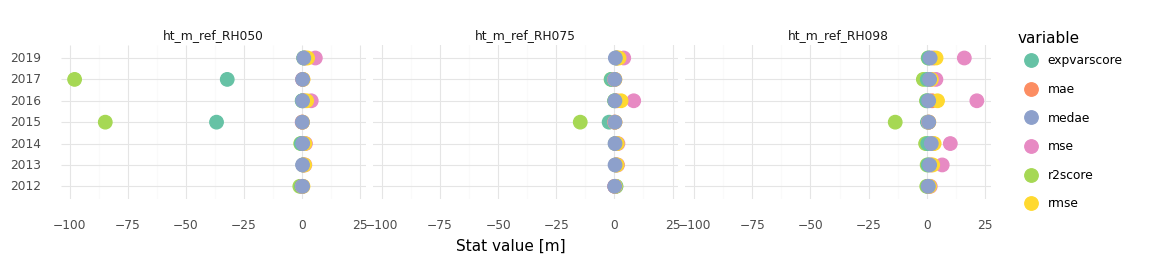

<ggplot: (1437480987405)>

In [249]:
( 
    ggplot(df_smry_year_m, aes(x='value', y='factor(year)', color='variable'))
        + geom_point(size=5)
    + scale_color_brewer(type='qual', palette=7)
    + labs(y = None, x = 'Stat value [m]')
    + facet_grid('~ ref_var')
    + theme_minimal()
    + theme(figure_size = (12,2))

)


# Use vhr metadata to examine predictions = 0  
 - do these 0 vals come from only a few strips?  
 - is there a link to sub-optimal SSG?